In [2306]:
# https://www.kaggle.com/datasets/michaelbryantds/cpu-and-gpu-product-data

### Análise e Entendimento do Problema:

#### Especificação do objetivo geral e dos objetivos específicos

O Objetivo geral do projeto é identificar a relação entre a quantidade dos transistors presentes nos processadores e qual a influência que o tamanho, TDP, entre outras características tem sob o processamento. Dentre os objetivos específicos está o tratamento das informações removendo os outliers, padronizando os dados, analisando as alterações, entre outros.

### a. Especificação do tipo de problema: Quanto à Supervisão, Quanto à Tarefa, Quanto ao Modo;

À FAZER 


b. Especificação das Medidas de Desempenho (para Classificação ou Regressão)


Como metódos de desempenho, os principais utilizados no nosso projeto, se tratam de acurácia para a Classicação e erro quadrático médio para Regressão, esses metódos, são extremamente importantes, pois é através deles que é possível observar o quão precisas estão sendo as predições realizadas pela máquina, por serem duas formas diferentes de Aprendizado de máquina supervisionado, cada um possui seu próprio método de desempenho, para a classificação usaremos o principal citado anteriormente, acurácia, se trata de um indicador da performance geral do modelo, contando quantas classificações foram feitas corretamente, para ser calculado, se torna necessário utilizar a Matriz de confusão, identificando os verdadeiros positivos, falso negativos, falso positivos e verdadeiros negativos, através desses dados é possível montar a Matriz e utilizar a formúla VP+VN/VP+VN+FP+FN para assim medir a acurácia do modelo, já para a regressão utilizaremos o erro quadrático médio, esse método carrega como objetivo encontrar a diferença dos valores iniciais com os valores preditos, quanto mais alta a diferença, maior o problema do modelo, pois os valores encontrados não estão sendo precisos, essa média é calculada através da diferença do valor predito para o valor real, o resultado é elevado ao quadrado, fazendo isso para todos os pontos, como já dito, quanto maior o resultado, mais pobre estão sendo as predições.

##### Hipótese

Com o avanço tecnológico e embasados na lei de Moore, observa-se um crescimento exponencial de transistores em unidades de processamento (CPU's & GPU's) em função do tempo. De forma inversamente proporcional, é perceptível a redução do tamanho dos componentes. Neste projeto, utilizando 2 modelos de aprendizado de máquina, regressão linear e KNN (K-ésimo Vizinho mais Próximo), buscamos prever a quantidade de transistores de uma UDP tendo como parâmetros a TDP (Thermal design power) e seu Die Size. 

# Análise de dados:

In [2307]:
import pandas as pd
import numpy as np
import random
import string
import sklearn
from itertools import groupby
import plotly.express as px
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import neighbors
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from math import sqrt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as sts
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

### Obtenção dos dados

In [2308]:
df = pd.read_csv('chip_dataset.csv', index_col=0)

Excluindo colunas sem utilidade

########### Explicação

In [2309]:
df.drop('FP16 GFLOPS', axis=1, inplace=True)
df.drop('FP32 GFLOPS', axis=1, inplace=True)
df.drop('FP64 GFLOPS', axis=1, inplace=True)

 Selecionando coluna aleatória

In [2310]:
# escolhendo uma coluna aleatoriamente
random.seed(13)
n = random.randrange(0,len(df.columns))
coluna_aleatoria = df.columns[n]
coluna_aleatoria

'TDP (W)'

In [2311]:
df.head()

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor
0,AMD Athlon 64 3500+,CPU,2007-02-20,65.0,45.0,77.0,122.0,2200.0,Unknown,AMD
1,AMD Athlon 200GE,CPU,2018-09-06,14.0,35.0,192.0,4800.0,3200.0,Unknown,AMD
2,Intel Core i5-1145G7,CPU,2020-09-02,10.0,28.0,NaN,NaN,2600.0,Intel,Intel
3,Intel Xeon E5-2603 v2,CPU,2013-09-01,22.0,80.0,160.0,1400.0,1800.0,Intel,Intel
4,AMD Phenom II X4 980 BE,CPU,2011-05-03,45.0,125.0,258.0,758.0,3700.0,Unknown,AMD


### Modificação dos Dados para gerar novos desafios

##### Selecionando 3% dos dados

In [2312]:
p_3 = round(df.shape[0] * 3 / 100)
p_3

146

##### Excluindo 3% dos dados aleatoriamente

In [2313]:
reg_excluidos = df.sample(n=p_3)
reg_exc_index = reg_excluidos.index.array
df.loc[reg_exc_index, coluna_aleatoria] = np.nan

In [2314]:
# listando alterações
df.loc[reg_exc_index]

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor
855,AMD Phenom II X4 975 BE,CPU,2011-01-04,45.0,NaN,258.0,758.0,3600.0,Unknown,AMD
282,AMD A10-5800B,CPU,2012-10-02,32.0,NaN,246.0,1178.0,3800.0,Unknown,AMD
886,Intel Pentium III 1133,CPU,2001-06-01,180.0,NaN,80.0,44.0,1133.0,Intel,Intel
4291,NVIDIA Quadro 6000 SDI,GPU,2011-07-25,40.0,NaN,529.0,3100.0,574.0,TSMC,NVIDIA
1526,AMD EPYC Embedded 3251,CPU,2018-02-21,14.0,NaN,213.0,4800.0,2500.0,GF,AMD
...,...,...,...,...,...,...,...,...,...,...
92,Intel Xeon MP 3.50,CPU,2005-03-29,90.0,NaN,NaN,NaN,3500.0,Intel,Intel
476,AMD Sempron 3000+,CPU,2001-01-01,130.0,NaN,144.0,69.0,1800.0,Unknown,AMD
1770,Intel Celeron N2830,CPU,2014-02-23,22.0,NaN,NaN,NaN,2160.0,Intel,Intel
3476,NVIDIA GeForce GTX 1650 TU106,GPU,2020-06-18,12.0,NaN,445.0,10800.0,1410.0,TSMC,NVIDIA


##### Alterando 3% dos dados aleatoriamente

In [2315]:
def gerar_string_aleatoria():
  letters = string.ascii_lowercase
  return ''.join(random.choice(letters) for i in range(10)) 

def gerar_numero_aleatorio():
  return random.randint(0, 999)

In [2316]:
# listando indexes que sofrerão alteração na coluna aleatória
df_selecao_nao_nulo = df[~df[coluna_aleatoria].isnull()]
reg_alterados = df_selecao_nao_nulo.sample(n=p_3)
reg_alter_index = reg_alterados.index.array

In [2317]:
# inserindo alterações na coluna aleatória
colunas_numericas = df.describe().columns

if coluna_aleatoria in colunas_numericas:
    for index in reg_alter_index:
        df.loc[[index],[coluna_aleatoria]] = gerar_numero_aleatorio()
else:
    for index in reg_alter_index:
        df.loc[[index],[coluna_aleatoria]] = gerar_string_aleatoria()

In [2318]:
# listando alterações
df.loc[reg_alter_index]

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor
4732,NVIDIA GeForce G205M,GPU,2009-01-08,65.0,297.0,144.0,314.0,450.0,Unknown,NVIDIA
2216,NVIDIA GRID K140Q,GPU,2013-06-28,28.0,701.0,118.0,1270.0,850.0,TSMC,NVIDIA
405,Intel Core i5-2435M,CPU,2011-09-01,32.0,931.0,149.0,624.0,2400.0,Intel,Intel
1286,Intel Atom S1260,CPU,2012-12-11,32.0,700.0,NaN,NaN,2000.0,Intel,Intel
676,Intel Xeon Platinum 8380H,CPU,2021-04-06,14.0,821.0,NaN,NaN,2900.0,Intel,Intel
...,...,...,...,...,...,...,...,...,...,...
3690,ATI FirePro M7820,GPU,2010-05-01,40.0,359.0,166.0,1040.0,700.0,TSMC,ATI
3,Intel Xeon E5-2603 v2,CPU,2013-09-01,22.0,207.0,160.0,1400.0,1800.0,Intel,Intel
452,AMD Phenom II X3 B73,CPU,2009-10-01,45.0,722.0,258.0,758.0,2800.0,Unknown,AMD
4420,NVIDIA Quadro Plex 1000 Model II,GPU,2008-07-25,110.0,874.0,333.0,302.0,470.0,TSMC,NVIDIA


#### Tratamento de registros nulos em colunas descritivas. 
*       Estratégia adotada: exclusão.

In [2319]:
# Exlusão dos registros nulos nas colunas categoricas
colunas_descritivas = [x for x in list(df.columns) if x not in list(df.describe().columns)]
for col in colunas_descritivas:
    df = df[pd.notnull(df[col])]

#### Tratamento de registros duplicados. 
*       Estratégia: exclusão.

In [2320]:
df.duplicated().sum()

111

In [2321]:
df.drop_duplicates(inplace=True)

#### Tratamento de registros nulos em colunas numéricas. 
*       Estratégia adotada: inserção da média.

In [2322]:
df.isnull().sum()

Product                    0
Type                       0
Release Date               0
Process Size (nm)          9
TDP (W)                  729
Die Size (mm^2)          682
Transistors (million)    687
Freq (MHz)                 0
Foundry                    0
Vendor                     0
dtype: int64

In [2323]:
def imputer_mean(coluna):
    df[coluna] = df[coluna].fillna(df[coluna].mean())
    
for col in list(df.describe().columns):
    imputer_mean(col)

#### Divisão (Amostragem Estratificada)

In [2324]:
# A amostragem estratificada classifca a quantidade de transistors em ranks, sendo assim possível realizar a contagem da quantidade de processadores que possuem um range da quantidade 
# de transistors

# < 250:                Rank F
# >= 250 & < 500:       Rank E
# >= 500 & < 1000:      Rank D
# >= 1000 & < 2000:     Rank C
# >= 2000 & < 6000:     Rank B
# >= 6000 & < 15000:    Rank A
# >= 15000 & < 30000:   Rank S 
# > 30000:              Rank S+ 

In [2325]:
df.reset_index(drop=True, inplace=True)

In [2326]:
def amostragem_estratificada(test_set):
    return (test_set['Rank'].value_counts() / len(test_set))*100

In [2327]:
ranges = [0, 250, 500, 1000, 2000, 6000, 15000, 30000, np.inf]
tiers = ['F', 'E', 'D', 'C', 'B', 'A', 'S', 'S+']

df['Rank'] = pd.cut(df['Transistors (million)'], bins = ranges, labels = tiers)

In [2328]:
df['Rank'].value_counts()

C     1405
F     1367
B      610
D      566
E      481
A      246
S       60
S+       8
Name: Rank, dtype: int64

In [2329]:
# Com base no gráfico é possível concluir que, nesta base de dados, os processadores com menos de 250 transistores são maioria, seguidos pelos de 1000 a 2000.

<AxesSubplot: xlabel='Rank', ylabel='count'>

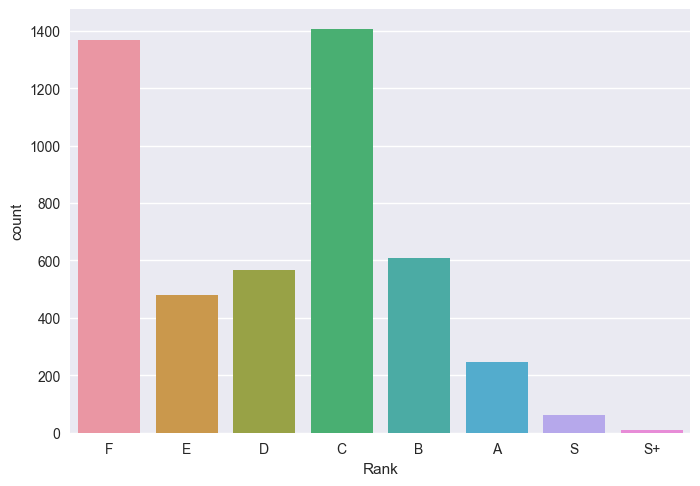

In [2330]:
sns.countplot(x='Rank', data=df, order=tiers)

#### Exploração 

##### Busca de correlações (Coeficientes de correlação)

In [2331]:
colunas_para_calculo = df.describe().columns
print('Coeficiente de correlação de Pearson entre a coluna Die Size (mm^2) e:')

coor_dict = {}
r_list = []

for value in df.corr()['Die Size (mm^2)']:
    if value == 1:
        r = 'relação linear perfeita e positiva'
    elif value == 0:
        r = 'inexistência linear'
    elif value == -1:
        r = 'relação linear perfeita e negativa'
    elif value > 0:
        r = 'relação linear positiva'
    elif value < 0:
        r = 'relação linear negativa'

    r_list.append(r)

print(df.corr(method='pearson', min_periods=1)['Transistors (million)'], '\n')

count = 0
for col in colunas_para_calculo: 
    coor_dict[col] = r_list[count]
    print(f'{col}: {coor_dict[col]}')
    count += 1

Coeficiente de correlação de Pearson entre a coluna Die Size (mm^2) e:
Process Size (nm)       -0.383921
TDP (W)                  0.264035
Die Size (mm^2)          0.628500
Transistors (million)    1.000000
Freq (MHz)               0.015491
Name: Transistors (million), dtype: float64 

Process Size (nm): relação linear negativa
TDP (W): relação linear positiva
Die Size (mm^2): relação linear perfeita e positiva
Transistors (million): relação linear positiva
Freq (MHz): relação linear positiva


C:\Users\anjos\AppData\Local\Temp\ipykernel_12200\939001549.py:7: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

C:\Users\anjos\AppData\Local\Temp\ipykernel_12200\939001549.py:21: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



## Análise dos dados

In [2332]:
df_an = df.copy()
df_an.set_index('Release Date', inplace=True)
df_an.sort_index(inplace=True)

In [2333]:
df_cpu = df_an[df_an["Type"] == "CPU"]
df_gpu = df_an[df_an["Type"] == "GPU"]

### Análise da quantidade dos transistores x tamanho do núcleo por ano

#### CPU

In [2334]:
fig_transistors = make_subplots()
fig_die = make_subplots()

# Add traces
fig_transistors.add_trace(
    go.Scatter(x= df_an.index, y=df_cpu["Transistors (million)"] ,name= "CPU")
)
# Add figure title
fig_transistors.update_layout(
    title_text="CPU vs Transistors (million) evolution over years"
)
# Set x-axis title
fig_transistors.update_xaxes(title_text="Years")
# Set y-axes titles
fig_transistors.update_yaxes(title_text="<b>Transistors (million)", secondary_y=False)

# Add traces
fig_die.add_trace(
    go.Scatter(x= df_an.index, y=df_cpu["Die Size (mm^2)"] ,name= "CPU")
)
# Add figure title
fig_die.update_layout(
    title_text="CPU vs Die Size (mm^2) evolution over years"
)
# Set x-axis title
fig_die.update_xaxes(title_text="Years")
# Set y-axes titles
fig_die.update_yaxes(title_text="<b>Die Size (mm^2)", secondary_y=False)

fig_transistors.show()
fig_die.show()

#### GPU

In [2335]:
fig_transistors = make_subplots()
fig_die = make_subplots()

# Add traces
fig_transistors.add_trace(
    go.Scatter(x= df_an.index, y=df_gpu["Transistors (million)"] ,name= "GPU")
)
# Add figure title
fig_transistors.update_layout(
    title_text="GPU vs Transistors (million) evolution over years"
)
# Set x-axis title
fig_transistors.update_xaxes(title_text="Years")
# Set y-axes titles
fig_transistors.update_yaxes(title_text="<b>Transistors (million)", secondary_y=False)

# Add traces
fig_die.add_trace(
    go.Scatter(x= df_an.index, y=df_gpu["Die Size (mm^2)"] ,name= "GPU")
)
# Add figure title
fig_die.update_layout(
    title_text="GPU vs Die Size (mm^2) evolution over years"
)
# Set x-axis title
fig_die.update_xaxes(title_text="Years")
# Set y-axes titles
fig_die.update_yaxes(title_text="<b>Die Size (mm^2)", secondary_y=False)

fig_transistors.show()
fig_die.show()

##### Analise de Transistors x Die Size

### Análise - Frequency

In [2336]:
fig = make_subplots()

# Add traces
fig.add_trace(
    go.Scatter(x= df_cpu.index, y=df_cpu["Freq (MHz)"] ,name= "CPU")
)

fig.add_trace(
    go.Scatter(x= df_gpu.index,y= df_gpu["Freq (MHz)"], name= "GPU")
)

# Add figure title
fig.update_layout(
    title_text="CPU/GPU vs Frequency (MHz) evolution over years"
)

# Set x-axis title
fig.update_xaxes(title_text="Years")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Freq (MHz)</b>", secondary_y=False)

fig.show()

### Análise - Proccess Size

In [2337]:
fig = make_subplots()

# Add traces
fig.add_trace(
    go.Scatter(x= df_cpu.index, y=df_cpu["Process Size (nm)"] ,name= "CPU")
)

fig.add_trace(
    go.Scatter(x= df_gpu.index,y= df_gpu["Process Size (nm)"], name= "GPU")
)

# Add figure title
fig.update_layout(
    title_text="CPU/GPU vs Process Size (nm) evolution over years"
)

# Set x-axis title
fig.update_xaxes(title_text="Years")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Process Size (nm)</b>", secondary_y=False)

fig.show()

## Pré-processamento dos dados

##### Normalização

In [2338]:
normalizacao_pipeline = Pipeline([
        ('std_scaler', MinMaxScaler())
    ])

##### Full Pipeline

In [2339]:
def full_pipe(dataframe):
    full_pipeline = ColumnTransformer([
            ('num_attr', normalizacao_pipeline, dataframe.describe().columns),
        ])
    
    return full_pipeline.fit_transform(dataframe)   

## Modelos

#### Divisão de conjuntos, treino e teste

In [2340]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(df, df['Rank']):
  train = df.loc[train_index]
  test = df.loc[test_index]

In [2341]:
train.drop(columns=['Rank'], inplace=True)
test.drop(columns=['Rank'], inplace=True)

In [2342]:
train_prepared = full_pipe(train)

In [2343]:
test_prepared = full_pipe(test)

### Regressão Linear

In [2344]:
def plot_set(x, y): 
    lin_reg = LinearRegression().fit(x, y)
    c_angular = lin_reg.coef_
    c_linear = lin_reg.intercept_
    plt.scatter(x, y)
    plt.xlabel('Transistors (million)')
    plt.ylabel('Die Size (mm^2)')
    plt.plot(x, c_linear + c_angular * x, color='red')
    plt.show()

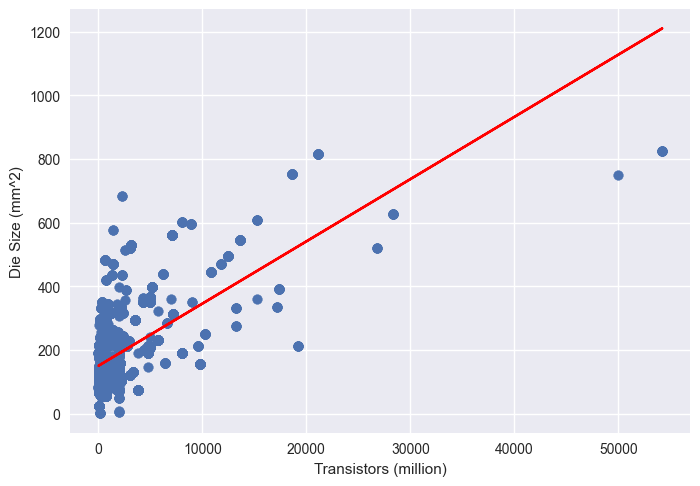

In [2345]:
plot_set(train[['Transistors (million)']], train[['Die Size (mm^2)']])

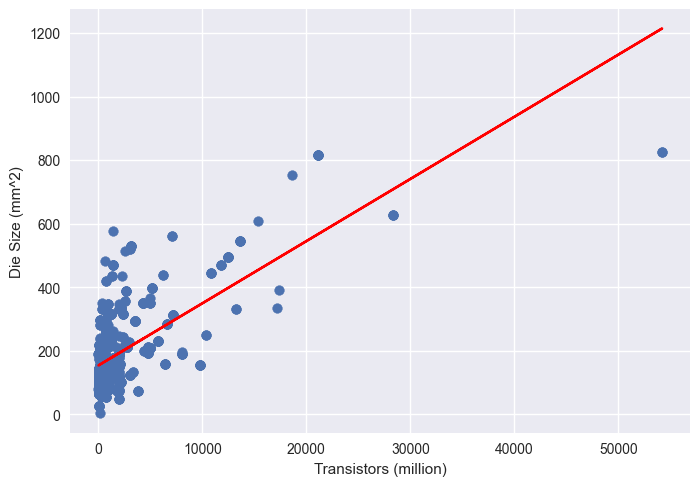

In [2346]:
plot_set(test[['Transistors (million)']], test[['Die Size (mm^2)']])

In [2347]:
cpu_labels = train['Transistors (million)'].copy()
cpu = train.drop(['Transistors (million)', 'Product', 'Type', 'Release Date', 'Foundry', 'Vendor'], axis=1)

In [2348]:
cpu_prepared = full_pipe(cpu)

In [2349]:
lin_reg = LinearRegression().fit(cpu.values, cpu_labels.values)

In [2350]:
cpu_predictions = lin_reg.predict(cpu_prepared)

In [2351]:
cpu

,Process Size (nm),TDP (W),Die Size (mm^2),Freq (MHz)
2630,40.0,238.000000,529.000000,574.0
2047,22.0,4.000000,189.514405,1580.0
3475,16.0,120.000000,200.000000,1506.0
343,7.0,180.000000,189.514405,3700.0
2183,40.0,14.000000,57.000000,525.0
...,...,...,...,...
2444,7.0,180.000000,335.000000,1489.0
3490,130.0,97.669656,281.000000,350.0
1644,45.0,80.000000,263.000000,1866.0
206,22.0,45.000000,160.000000,2700.0


##### Curva de treino

In [2352]:
features = ['Process Size (nm)', 'TDP (W)', 'Die Size (mm^2)', 'Freq (MHz)'] 
target = 'Transistors (million)'
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = LinearRegression(),
    X = train[features],
    y = train[target], 
    train_sizes = [1, 250, 500, 1000, 2000, 3000], cv = 5, scoring = 'neg_root_mean_squared_error')

In [2353]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

C:\Users\anjos\AppData\Local\Temp\ipykernel_12200\899385337.py:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



(0.0, 4080.0)

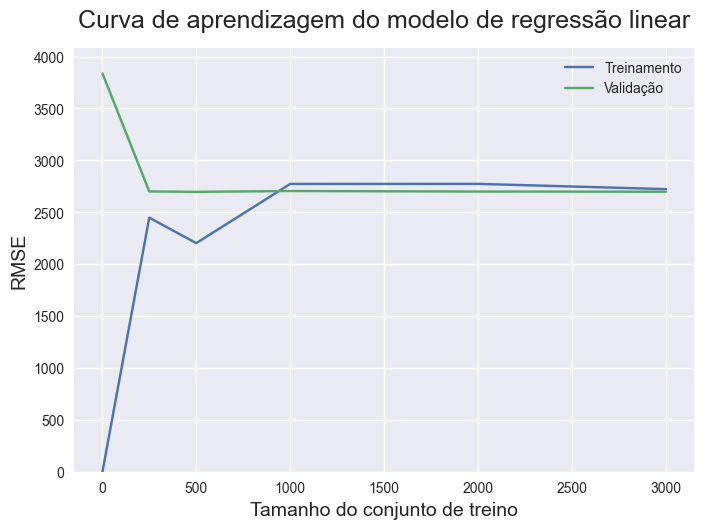

In [2354]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Treinamento')
plt.plot(train_sizes, validation_scores_mean, label = 'Validação')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Tamanho do conjunto de treino', fontsize = 14)
plt.title('Curva de aprendizagem do modelo de regressão linear', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0, 4080)

#### Erro Médio Quadrático

In [2355]:
lin_rmse = mean_squared_error(cpu_labels, cpu_predictions, squared=False)

In [2356]:
round(lin_rmse, 2)

4104.28

### KNN

In [2357]:
scaler = MinMaxScaler()

In [2358]:
train_x = train[['TDP (W)', 'Die Size (mm^2)']]
train_y = train['Transistors (million)']

train_x_scaled = scaler.fit_transform(train_x)

In [2359]:
test_x = test[['TDP (W)', 'Die Size (mm^2)']]
test_y = test['Transistors (million)']

test_x_scaled = scaler.fit_transform(test_x)

##### Curva de treino

In [2360]:
rmse_val = [] 
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(train_x, train_y)
    pred = model.predict(test_x)
    error = sqrt(mean_squared_error(test_y,pred))
    rmse_val.append(error) 

Text(0.5, 0, 'Valores de k')

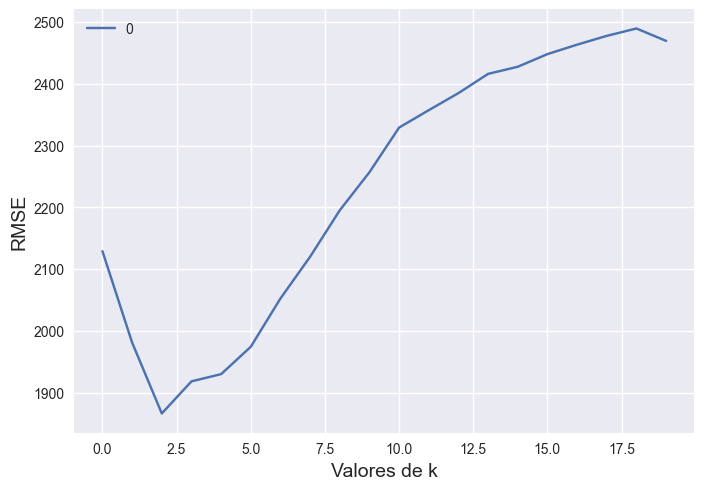

In [2361]:
curva = pd.DataFrame(rmse_val)
curva = curva.plot()
curva.set_ylabel('RMSE', fontsize = 14)
curva.set_xlabel('Valores de k', fontsize = 14)

In [2362]:
features = ['Process Size (nm)', 'TDP (W)', 'Die Size (mm^2)', 'Freq (MHz)'] 
target = 'Transistors (million)'
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = KNeighborsRegressor(),
    X = train[features],
    y = train[target], 
    train_sizes = [1, 250, 500, 1000, 2000, 3000], cv = 5, scoring = 'neg_root_mean_squared_error')

C:\Users\anjos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:776: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\anjos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\anjos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\anjos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_scorer.py", line 261,

In [2363]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

C:\Users\anjos\AppData\Local\Temp\ipykernel_12200\824158580.py:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



(0.0, 2700.0)

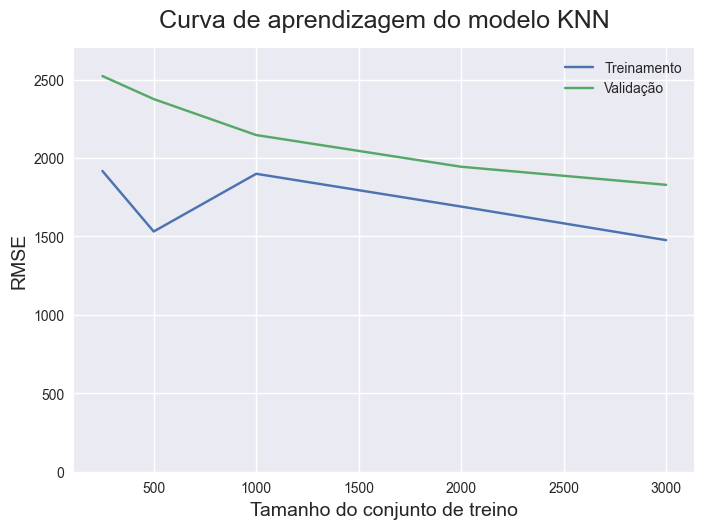

In [2364]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Treinamento')
plt.plot(train_sizes, validation_scores_mean, label = 'Validação')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Tamanho do conjunto de treino', fontsize = 14)
plt.title('Curva de aprendizagem do modelo KNN', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0, 2700)